In [408]:
import random
import numpy as np
from scipy.sparse import dia_array
from scipy.sparse.linalg import spsolve


# import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Samples Generator

In [244]:
def tensor2matrix(t):
    ni, nj = t[0].shape

    diag_ni_u = torch.flatten(t[0].transpose(0,1))
    diag_1_u = torch.flatten(t[1].transpose(0,1))
    diag_1_l = torch.flatten(t[2].transpose(0,1))
    diag_ni_l = torch.flatten(t[3].transpose(0,1))

    n_diag = ni*nj
    main_diag = np.ones(n_diag)
    data = np.array([diag_ni_l,diag_1_l, main_diag, diag_1_u,diag_ni_u])
    offsets = np.array([-ni,-1, 0, 1,ni])
    m = dia_array((data, offsets), shape=(n_diag, n_diag))

    return m

def make_tensor(number_generator,
                args={},
                symmetric=True,
                off_diagonal_abs_mean=0.5,
                grid_size=(5, 5)):

    #Generate values
    ni, nj = grid_size
    n_diag_1 = (ni-1)*nj
    n_diag_ni = ni*(nj-1)

    diag_1_u = [number_generator(**args) for _ in range(n_diag_1)]
    diag_ni_u = [number_generator(**args) for _ in range(n_diag_ni)]

    if symmetric:
        diag_1_l = diag_1_u
        diag_ni_l = diag_ni_u
    else:
        diag_1_l = [number_generator(**args) for _ in range(n_diag_1)]
        diag_ni_l = [number_generator(**args) for _ in range(n_diag_ni)]

    #To tensor
    diag_1_u = torch.tensor(diag_1_u).float()
    diag_1_l = torch.tensor(diag_1_l).float()
    diag_ni_u = torch.tensor(diag_ni_u).float()
    diag_ni_l = torch.tensor(diag_ni_l).float()

    #Scale off main diagonal
    off_diagonal = torch.cat([diag_ni_u, diag_1_u, diag_1_l, diag_ni_l])
    off_diagonal = torch.abs(off_diagonal)
    mean_abs = torch.mean(off_diagonal)
    alpha = off_diagonal_abs_mean / mean_abs
    diag_1_u = torch.mul(diag_1_u, alpha)
    diag_1_l = torch.mul(diag_1_l, alpha)
    diag_ni_u = torch.mul(diag_ni_u, alpha)
    diag_ni_l = torch.mul(diag_ni_l, alpha)

    #Adjust zeroes
    diag_1_u = torch.reshape(diag_1_u, (ni-1,nj))
    diag_1_u = torch.cat([torch.zeros(1,nj), diag_1_u], dim=0)

    diag_1_l = torch.reshape(diag_1_l, (ni-1,nj))
    diag_1_l = torch.cat([diag_1_l, torch.zeros(1,nj)], dim=0)

    diag_ni_l = torch.reshape(diag_ni_l, (ni,nj-1))
    diag_ni_l = torch.cat([diag_ni_l, torch.zeros(ni,1)], dim=1)

    diag_ni_u = torch.reshape(diag_ni_u, (ni,nj-1))
    diag_ni_u = torch.cat([torch.zeros(ni,1), diag_ni_u], dim=1)

    t = torch.cat([diag_ni_u.unsqueeze(0),
                    diag_1_u.unsqueeze(0),
                    diag_1_l.unsqueeze(0),
                    diag_ni_l.unsqueeze(0)],
                    dim=0)
    return t

In [245]:
def get_sample(number_generator,
               args={},
               symmetric=True,
               off_diagonal_abs_mean=0.5,
               grid_size=(5, 5)):

    A = make_tensor(number_generator=number_generator,
                    args=args,
                    symmetric=symmetric,
                    off_diagonal_abs_mean=off_diagonal_abs_mean,
                    grid_size=grid_size)

    ni, nj = grid_size
    n_diag = ni*nj
    x_true = [number_generator(**args) for _ in range(n_diag)]

    A_mat = tensor2matrix(A)
    b = A_mat.dot(x_true)
    b = torch.tensor(b, dtype=torch.float32)
    b = torch.reshape(b, (nj,ni)).transpose(0,1)

    X = torch.cat([A, b.unsqueeze(0)], dim=0)
    x_true = torch.tensor(x_true).float()
    y = torch.reshape(x_true, (nj,ni)).transpose(0,1)
    return (X, y)

In [401]:
def check_sample(X, y, result='max', print_cond_number=False, verbose=False):

    def _error_from_y(X,y):
        custom_weights = np.array([
            [[0, 0, 0],
             [0, 1, 0],
             [0, 0, 0]],
            [[0, 0, 0],
             [0, 0, 1],
             [0, 0, 0]],
            [[0, 0, 0],
             [0, 0, 0],
             [0, 1, 0]],
            [[0, 1, 0],
             [0, 0, 0],
             [0, 0, 0]],
            [[0, 0, 0],
             [1, 0, 0],
             [0, 0, 0]],
            ], dtype=np.float32)
        custom_weights_tensor = torch.tensor(custom_weights).unsqueeze(0)  # Add batch dimensions
        conv_layer = nn.Conv2d(in_channels=5, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        conv_layer.weight = nn.Parameter(custom_weights_tensor, requires_grad=False)

        ni, nj = X[0].shape
        X_ = torch.cat([torch.ones((ni,nj)).unsqueeze(0), X[:4]])
        residuals = conv_layer(X_ * y) - X[-1]
        residuals = torch.flatten(residuals.transpose(0,1))
        return residuals

    def _error_from_solve(X):
        A = tensor2matrix(X[:4])
        b = torch.flatten(X[-1].transpose(0,1)).tolist()
        y_aprox = spsolve(A.tocsr(), b)
        residuals = A.dot(y_aprox) - b
        y_aprox = torch.tensor(y_aprox)
        residuals = torch.tensor(residuals)
        return residuals, y_aprox

    def _get_result(output_tensor, reference_tensor):
        if result == 'sum_abs':
            return float(torch.sum(torch.abs(output_tensor)))
        if result == 'max':
            return float(torch.max(torch.abs(output_tensor)))
        if result == 'sum2':
            return float(torch.sum(torch.square(output_tensor)))
        if result == 'max_rel':
            return float(torch.max(torch.abs(output_tensor) / torch.abs(reference_tensor)))
        raise ValueError(f'Invalid option: {result}.')


    y_ = torch.flatten(y.transpose(0,1))
    if print_cond_number and verbose:
        A = tensor2matrix(X[:4])
        cond_num = np.linalg.cond(A.toarray())
        print(f'Matrix condition number: {cond_num:0.4g}')

    residuals_from_y = _error_from_y(X,y)
    error_from_y = _get_result(residuals_from_y, y_)

    residuals_from_solve, y_aprox = _error_from_solve(X)
    error_from_solve = _get_result(residuals_from_solve, y_)
    error_delta_y = _get_result(y_ - y_aprox, y_)

    if verbose:
        print(f'Result using provided y: {error_from_y:0.4g}')
        print(f'Result using sparse solver: {error_from_solve:0.4g}')
        print(f'Difference in y vectors: {error_delta_y:0.4g}')

    return residuals_from_y, residuals_from_solve, y_aprox, y_

In [404]:
ni, nj = 100, 100
number_generator = random.uniform
args = {'a':1,'b':5}

X, y = get_sample(
    number_generator=number_generator,
    args=args,
    grid_size=(ni,nj),
    off_diagonal_abs_mean=0.5,
    symmetric=False)
print(f'X: {X.shape}')
print(f'Dense matrix: {tensor2matrix(X[:4]).shape}')
print(f'y: {y.shape}')

check_sample(X,y, 'max_rel', print_cond_number=False, verbose=True) #max, sum_abs, sum2, max_rel

X: torch.Size([5, 100, 100])
Dense matrix: (10000, 10000)
y: torch.Size([100, 100])
Result using provided y: 1.529e-06
Result using sparse solver: 3.233e-14
Difference in y vectors: 7.107e-05


(tensor([ 0.0000e+00, -4.7684e-07,  0.0000e+00,  ...,  4.7684e-07,
          0.0000e+00,  0.0000e+00]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64),
 tensor([2.2455, 1.7296, 2.7313,  ..., 1.7797, 2.2723, 3.9846],
        dtype=torch.float64),
 tensor([2.2455, 1.7296, 2.7314,  ..., 1.7797, 2.2723, 3.9847]))

## Dataloader

In [479]:
number_generator = random.uniform
args = {'a':-5,'b':5}
off_diagonal_abs_mean=0.5

class CustomDataset(Dataset):
    def __init__(self, ni, nj, n):
        self.ni = ni
        self.nj = nj
        self.n  = n

    def __len__(self):
        return self.n

    def __getitem__(self, idx):

        X, y = get_sample(
            number_generator=number_generator,
            args=args,
            grid_size=(self.ni,self.nj),
            off_diagonal_abs_mean=off_diagonal_abs_mean,
            symmetric=False)

        return (X, y.unsqueeze(0))

In [480]:
ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
batch_size = 64
dataloader_ = DataLoader(data_train, batch_size=batch_size, shuffle=False)

for X,y in dataloader_:
    print(f'Input shape: {X.shape}')
    print(f'Output shape: {y.shape}')
    break

Input shape: torch.Size([64, 5, 10, 10])
Output shape: torch.Size([64, 1, 10, 10])


## Neural Network Definition

In [470]:
class Network(nn.Module):

    def __init__(self, n_blocks, latent_size, activation=True):
        super(Network,self).__init__()

        self.input = nn.Conv2d(5, latent_size, 1, padding=0)

        self.process = nn.ModuleList()
        for _ in range(n_blocks):
            self.process.append(nn.Conv2d(latent_size, latent_size, 3, padding=1))

        self.output = nn.Conv2d(latent_size, 1, 1, padding=0)

        if activation:
            self.activation = F.relu
        else:
            self.activation = nn.Identity

    def forward(self, x):

        x = self.input(x)
        x = self.activation(x)

        for layer in self.process:
            x = layer(x)
            x = self.activation(x)

        x = self.output(x)

        return x

In [481]:
model = Network(
    n_blocks=5,
    latent_size=8,
    activation=True)

X, y = get_sample(
            number_generator=number_generator,
            args=args,
            grid_size=(ni,nj),
            off_diagonal_abs_mean=off_diagonal_abs_mean,
            symmetric=False)

print(f'Input: {X.shape}')
loss_fn = nn.MSELoss()
result = model(X)
print(f'Result: {result.shape}')

loss = loss_fn(result, y)
loss.backward()
print(f'Loss = {loss:0.2f}')

Input: torch.Size([5, 10, 10])
Result: torch.Size([1, 10, 10])
Loss = 8.03


In [482]:
print(model)

Network(
  (input): Conv2d(5, 8, kernel_size=(1, 1), stride=(1, 1))
  (process): ModuleList(
    (0-4): 5 x Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (output): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [483]:
total = 0
for name, param in model.named_parameters():
    print(f"Layer: {name} | Parameters: {param.numel()}")
    total += param.numel()
print(f'Total: {total}')

Layer: input.weight | Parameters: 40
Layer: input.bias | Parameters: 8
Layer: process.0.weight | Parameters: 576
Layer: process.0.bias | Parameters: 8
Layer: process.1.weight | Parameters: 576
Layer: process.1.bias | Parameters: 8
Layer: process.2.weight | Parameters: 576
Layer: process.2.bias | Parameters: 8
Layer: process.3.weight | Parameters: 576
Layer: process.3.bias | Parameters: 8
Layer: process.4.weight | Parameters: 576
Layer: process.4.bias | Parameters: 8
Layer: output.weight | Parameters: 8
Layer: output.bias | Parameters: 1
Total: 2977


## Train NN

In [474]:
device = 'cpu'

In [475]:
def plot_losses(train_losses, val_losses):
    plt.plot(range(1,len(train_losses)+1), train_losses, label='Train')
    plt.plot(range(1,len(train_losses)+1), val_losses, label='Val')
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title("Model Training")
    plt.legend()
    plt.grid(True)
    plt.show()

In [485]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        losses.append(loss)

        loss.backward()
        optimizer.step()

        if verbose:
            if batch % 100 == 0:
                loss, current = loss.item(), batch * batch_size + len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return float(torch.tensor(losses).mean())

def test_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

# https://tutorials.pytorch.kr/intermediate/torch_compile_tutorial.html
# train_opt = torch.compile(train_loop, mode="reduce-overhead")
# test_opt = torch.compile(test_loop, mode="reduce-overhead")

def train(model: Network,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          epochs: int,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          scheduler=None,
          file_name='model.pth',
          verbose=False):

    model.to(device)

    best_val = np.inf
    train_loss = []
    val_loss = []
    print("=> Starting training")
    for t in range(epochs):
        if verbose:
            print(f"Epoch {t+1}\n-------------------------------")
        train_loss.append(train_loop(train_dataloader, model, loss_fn, optimizer, verbose))
        val_loss.append(test_loop(val_dataloader, model, loss_fn))
        star = ''
        if val_loss[-1]*1.01 < best_val:
            best_val = val_loss[-1]
            torch.save(model, file_name)
            star = '*'
        if scheduler is not None:
            scheduler.step(val_loss[-1])
        print(f' {t + 1}: train = {train_loss[-1]:0.4g}, val = {val_loss[-1]:0.4g}{star}, lr = {scheduler.get_last_lr()[0]}')
    print("Done!")
    best_model = torch.load(file_name)
    return best_model, (train_loss, val_loss)

RuntimeError: Dynamo is not supported on Python 3.12+

=> Starting training
 1: train = 5.749, val = 4.848*, lr = 0.001
 2: train = 4.518, val = 4.583*, lr = 0.001
 3: train = 4.064, val = 3.949*, lr = 0.001
 4: train = 3.887, val = 3.879*, lr = 0.001
 5: train = 3.763, val = 3.681*, lr = 0.001
 6: train = 3.64, val = 3.563*, lr = 0.001
 7: train = 3.532, val = 3.479*, lr = 0.001
 8: train = 3.434, val = 3.403*, lr = 0.001
 9: train = 3.37, val = 3.391, lr = 0.001
 10: train = 3.332, val = 3.349*, lr = 0.001
 11: train = 3.31, val = 3.304*, lr = 0.001
 12: train = 3.274, val = 3.543, lr = 0.001
 13: train = 3.235, val = 3.196*, lr = 0.001
 14: train = 3.188, val = 3.152*, lr = 0.001
 15: train = 3.138, val = 3.625, lr = 0.001
 16: train = 3.106, val = 3.109*, lr = 0.001
 17: train = 3.078, val = 3.026*, lr = 0.001
 18: train = 3.041, val = 3.06, lr = 0.001
 19: train = 3.026, val = 3.042, lr = 0.001
 20: train = 3.004, val = 2.999, lr = 0.001
 21: train = 2.983, val = 3.048, lr = 0.001
 22: train = 2.986, val = 3.015, lr = 0.001
 23: train

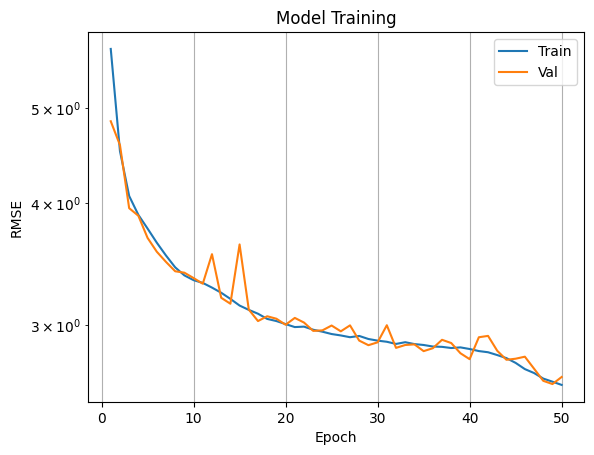

Test loss = 2.631 (last model)
Test loss = 2.631 (best model)


In [484]:
model = Network(
    n_blocks=5,
    latent_size=8,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 50
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')